In [1]:
# Load the Julia environment needed for this notebook
import Pkg
Pkg.activate("../../Tasks2D")

  Activating project at `~/Developer/research/fall2023/cocosci/tasks2D/Tasks2D`


In [3]:
import Makie   # Visualization Library
using Revise      # For development; makes it so modifications
                  # to imported modules are immediately reflected in this Julia session
using Gen         # Gen probabilistic programming library
import GenParticleFilters # Additional particle filtering functionality for Gen
import GridWorlds # Simple gridworld functionality
import LineWorlds
const L = LineWorlds
import LineWorlds: cast # Ray caster
import GenPOMDPs  # Beginnings of a Gen POMDP library

import Tasks2D
import LinearAlgebra

In [4]:
includet("src/Utils.jl")
includet("src/VizUtils.jl")

In [5]:
import GLMakie
GLMakie.activate!()

In [6]:
# Initial position model

# Distribution to sample uniformly from a Julia Set
using Tasks2D.Distributions: uniform_from_set

@gen (static) function uniform_agent_pos(params)
    w = params.map # a map, represented as a GridWorlds.GridWorld
    
    cell ~ uniform_from_set(GridWorlds.empty_cells(w))
    
    # Cell (i, j) corresponds to the region from i-1 to i and j-1 to j
    x ~ uniform(cell[1] - 1, cell[1])
    y ~ uniform(cell[2] - 1, cell[2])
    
    return ([x, y], 0, false)
end

var"##StaticGenFunction_uniform_agent_pos#251"(Dict{Symbol, Any}(), Dict{Symbol, Any}())

In [70]:
function pos_to_init_cm(pos)
    (x, y) = pos
    i = Int(ceil(x))
    j = Int(ceil(y))
    return choicemap(
        (:cell, (i, j)),
        (:x, x),
        (:y, y)
    )
end
function state_to_pos(state)
    return state[1]
end

state_to_pos (generic function with 1 method)

In [184]:
function det_next_pos(pos, a, Δ)
    (x, y) = pos
    a == :up    ? [x, y + Δ] :
    a == :down  ? [x, y - Δ] : 
    a == :left  ? [x - Δ, y] :
    a == :right ? [x + Δ, y] :
    a == :stay  ? [x, y]     :
                error("Unrecognized action: $a")
end

function handle_wall_intersection(prev, new, gridworld)
    walls = GridWorlds.nonempty_segments(gridworld)
    move = L.Segment(prev, new)
    
    min_collision_dist = Inf
    vec_to_min_dist_collision = nothing
    for i in 1:(size(walls)[1])
        wall = walls[i, :]
        # print("wall: $wall")
        do_intersect, dist = L.Geometry.cast(move, L.Segment(wall))

        if do_intersect && dist ≤ L.Geometry.norm(move)
            if dist < min_collision_dist
                min_collision_dist = dist
                vec_to_min_dist_collision = L.Geometry.diff(move)
            end
        end
    end
    
    if !isnothing(vec_to_min_dist_collision)
        dist = min_collision_dist
        if dist < 0.05
            return (prev, true)
        else
            normalized_vec = (vec_to_min_dist_collision / L.Geometry.norm(vec_to_min_dist_collision))
            collision_pt = prev + (dist - 0.04) * normalized_vec
            return (collision_pt, true)
        end
    end
    
    return (new, false)
end

handle_wall_intersection (generic function with 1 method)

In [385]:
@gen (static) function motion_model(state, action, params)
    (a, wall_clock_time) = action
    (pos, t_prev, prev_hit_wall) = state
    w, σ = params.map, params.step.σ
    
    next_pos_det = det_next_pos(pos, a, params.step.Δ)
    noisy_next_pos ~ broadcasted_normal(next_pos_det, params.step.σ)
    (next_pos, hit_wall) = handle_wall_intersection(pos, noisy_next_pos, w)
    
    return (next_pos, t_prev + 1, prev_hit_wall || hit_wall)
end
pos_to_step_cm(pos) = choicemap(
    (:noisy_next_pos, pos)
)
function nonoise_nextpos(pos, action, Δ, gridworld)
    (a, _) = action
    newpos = det_next_pos(pos, a, Δ)
    final_pos, did_collide = handle_wall_intersection(pos, newpos, gridworld)
    return final_pos
end

nonoise_nextpos (generic function with 1 method)

In [9]:
@gen function observe_noisy_distances(state, params)
    (pos, t, _) = state

    p = reshape([pos..., params.obs.orientation], (1, 3))
    _as = L.create_angles(params.obs.fov, params.obs.n_rays)
    wall_segs = GridWorlds.wall_segments(params.map)
    strange_segs = GridWorlds.strange_segments(params.map)
    @assert isempty(strange_segs) "Strange objects not supported in this model variant"
    
    w, s_noise, outlier, outlier_vol, zmax = params.obs.wall_sensor_args
    dists_walls = L.cast(p, wall_segs; num_a=params.obs.n_rays, zmax)
    dists_walls = reshape(dists_walls, (:,))

    wall_measurements = dists_walls
    obs ~ Gen.broadcasted_normal(wall_measurements, s_noise)

    return obs
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##observe_noisy_distances#296", Bool[0, 0], false)

In [10]:
# POMDP of this environment
pomdp = GenPOMDPs.GenPOMDP(
    uniform_agent_pos,       # INIT   : params                      ⇝ state
    motion_model,            # STEP   : prev_state, actions, params ⇝ state
    observe_noisy_distances, # OBS    : state, params               ⇝ observation
    (state, action) -> 0.    # UTILITY: state, action, params       → utility
)

GenPOMDPs.GenPOMDP(var"##StaticGenFunction_uniform_agent_pos#251"(Dict{Symbol, Any}(), Dict{Symbol, Any}()), var"##StaticGenFunction_motion_model#288"(Dict{Symbol, Any}(), Dict{Symbol, Any}()), DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##observe_noisy_distances#296", Bool[0, 0], false), var"#57#58"())

In [11]:
# Generative function over trajectories of the POMDP,
# given a fixed action sequence.
trajectory_model = GenPOMDPs.ControlledTrajectoryModel(pomdp)

GenPOMDPs.var"##StaticGenFunction__ControlledTrajectoryModel#368"(Dict{Symbol, Any}(), Dict{Symbol, Any}())

In [146]:
_get_params(map) = (;
    # map = GridWorlds.load_custom_map(5),
    map=map,
    step = (; Δ = .5, σ = 0.8),
    obs = (; fov = 2π, n_rays = 90, orientation = π/2,
        # I think currently only σ is used
        wall_sensor_args = (;
            w = 5, s_noise = 0.02,
            outlier = 0.0001,
            outlier_vol = 100.0,
            zmax = 100.0, σ=0.005
        )
    )
)

MAPSTR = """
wwwwwwwwwwwwwwwww
w               w
w        w      w
w        w      w
w        w      w
w        w      w
w               w
w               w
w               w
wwwwwwwwwwwwwwwww
"""
params = _get_params(GridWorlds.mapstr_to_gridworld(MAPSTR))

(map = GridWorlds.FGridWorld(FunctionalCollections.PersistentVector{GridWorlds.GridCell}[[GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall], [GridWorlds.wall, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.wall], [GridWorlds.wall, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.wall], [GridWorlds.wall, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.wall], [GridWorlds.wall, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.wall], [GridWorlds.wall, G

## Generate observed trace

(After you close the window it will save the trace.  If you want to use this in your experiments, copy the filename to the cell below.)

In [147]:
# UNCOMMENT THIS TO GENERATE A NEW GROUND TRUTH TRACE

# world_trace, take_action = VizUtils.get_interactive_trace(
#     trajectory_model, params,
#     choicemap((GenPOMDPs.state_addr(0, :cell), (3, 3)))  
# );

# (f, t, actions) = GridWorlds.Viz.interactive_gui(
#     t -> params.map, VizUtils.get_posobs_seq(world_trace), take_action,
#     save_fn=VizUtils.get_save_tr(world_trace),
#     show_lines_to_walls=true,
#     framerate=8,
#     close_on_hitwall=true,
#     did_hitwall_observable=VizUtils.get_did_hitwall_observable(world_trace),
#     # close_window=VizUtils.close_window,

#     # For playback
#     timing_args=VizUtils.get_timing_args(world_trace; speedup_factor=1, max_delay=5)
# )
# display(f)

GLMakie.Screen(...)

Trace & viz actions serialized to saves/2023-12-28T11:58:32.017__pomdp_trace.jld.
Trace & viz actions serialized to saves/2023-12-28T11:58:36.500__pomdp_trace.jld.
Trace & viz actions serialized to saves/2023-12-28T11:58:38.916__pomdp_trace.jld.


In [148]:
GROUNDTRUTH_TRACE_FILENAMES = [
    # traces in a very simple env:
    "saves/2023-12-27T12:54:47.359__pomdp_trace.jld", # highly deterministic
    "saves/2023-12-28T11:49:09.674__pomdp_trace.jld", # moderate motion noise
    "saves/2023-12-28T11:58:38.916__pomdp_trace.jld", # high motion noise
]

3-element Vector{String}:
 "saves/2023-12-27T12:54:47.359__pomdp_trace.jld"
 "saves/2023-12-28T11:49:09.674__pomdp_trace.jld"
 "saves/2023-12-28T11:58:38.916__pomdp_trace.jld"

## Load the trace

In [157]:
tr = Utils.deserialize_pomdp_trace(GROUNDTRUTH_TRACE_FILENAMES[2], trajectory_model)


GenPOMDPs.var"##StaticIRTrace__ControlledTrajectoryModel#367"(40, Any[(:right, Dates.DateTime("2023-12-28T11:48:49.749")), (:right, Dates.DateTime("2023-12-28T11:48:50.665")), (:right, Dates.DateTime("2023-12-28T11:48:50.983")), (:right, Dates.DateTime("2023-12-28T11:48:51.306")), (:right, Dates.DateTime("2023-12-28T11:48:51.703")), (:right, Dates.DateTime("2023-12-28T11:48:52.027")), (:right, Dates.DateTime("2023-12-28T11:48:52.279")), (:right, Dates.DateTime("2023-12-28T11:48:52.603")), (:right, Dates.DateTime("2023-12-28T11:48:52.927")), (:right, Dates.DateTime("2023-12-28T11:48:53.251"))  …  (:left, Dates.DateTime("2023-12-28T11:49:00.304")), (:left, Dates.DateTime("2023-12-28T11:49:00.556")), (:left, Dates.DateTime("2023-12-28T11:49:00.808")), (:left, Dates.DateTime("2023-12-28T11:49:00.988")), (:left, Dates.DateTime("2023-12-28T11:49:01.169")), (:up, Dates.DateTime("2023-12-28T11:49:01.636")), (:left, Dates.DateTime("2023-12-28T11:49:01.996")), (:up, Dates.DateTime("2023-12-28T11

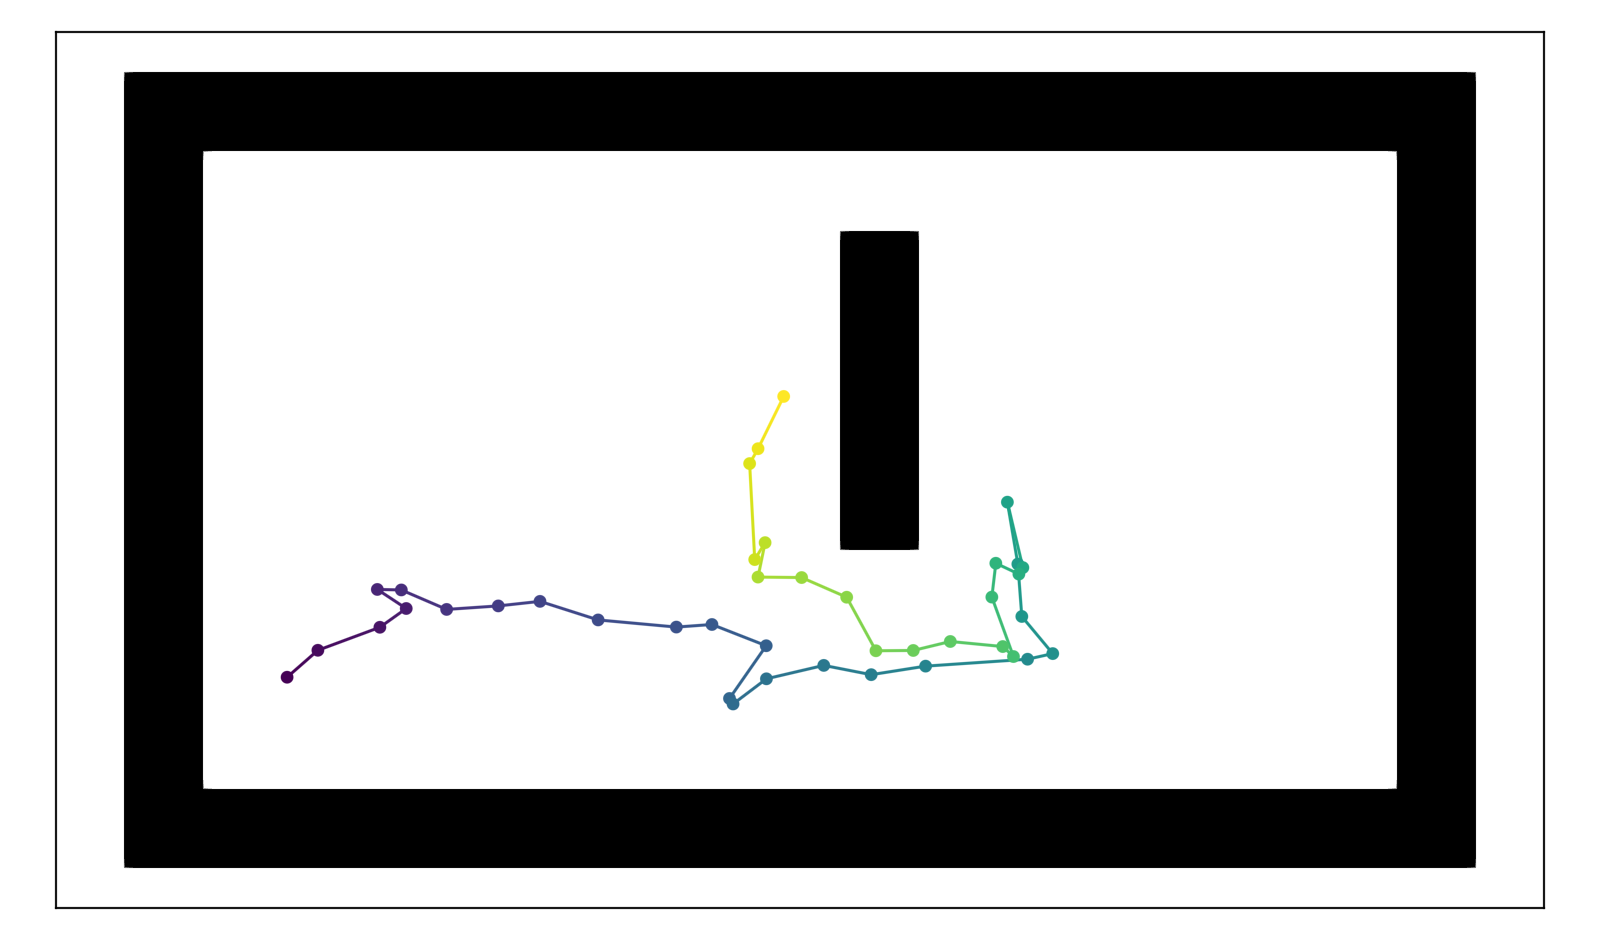

In [158]:
GridWorlds.Viz.plot_paths(
    get_args(tr)[3].map,
    [
        [pos for (pos, _, _) in GenPOMDPs.state_sequence(tr)]
    ]
)

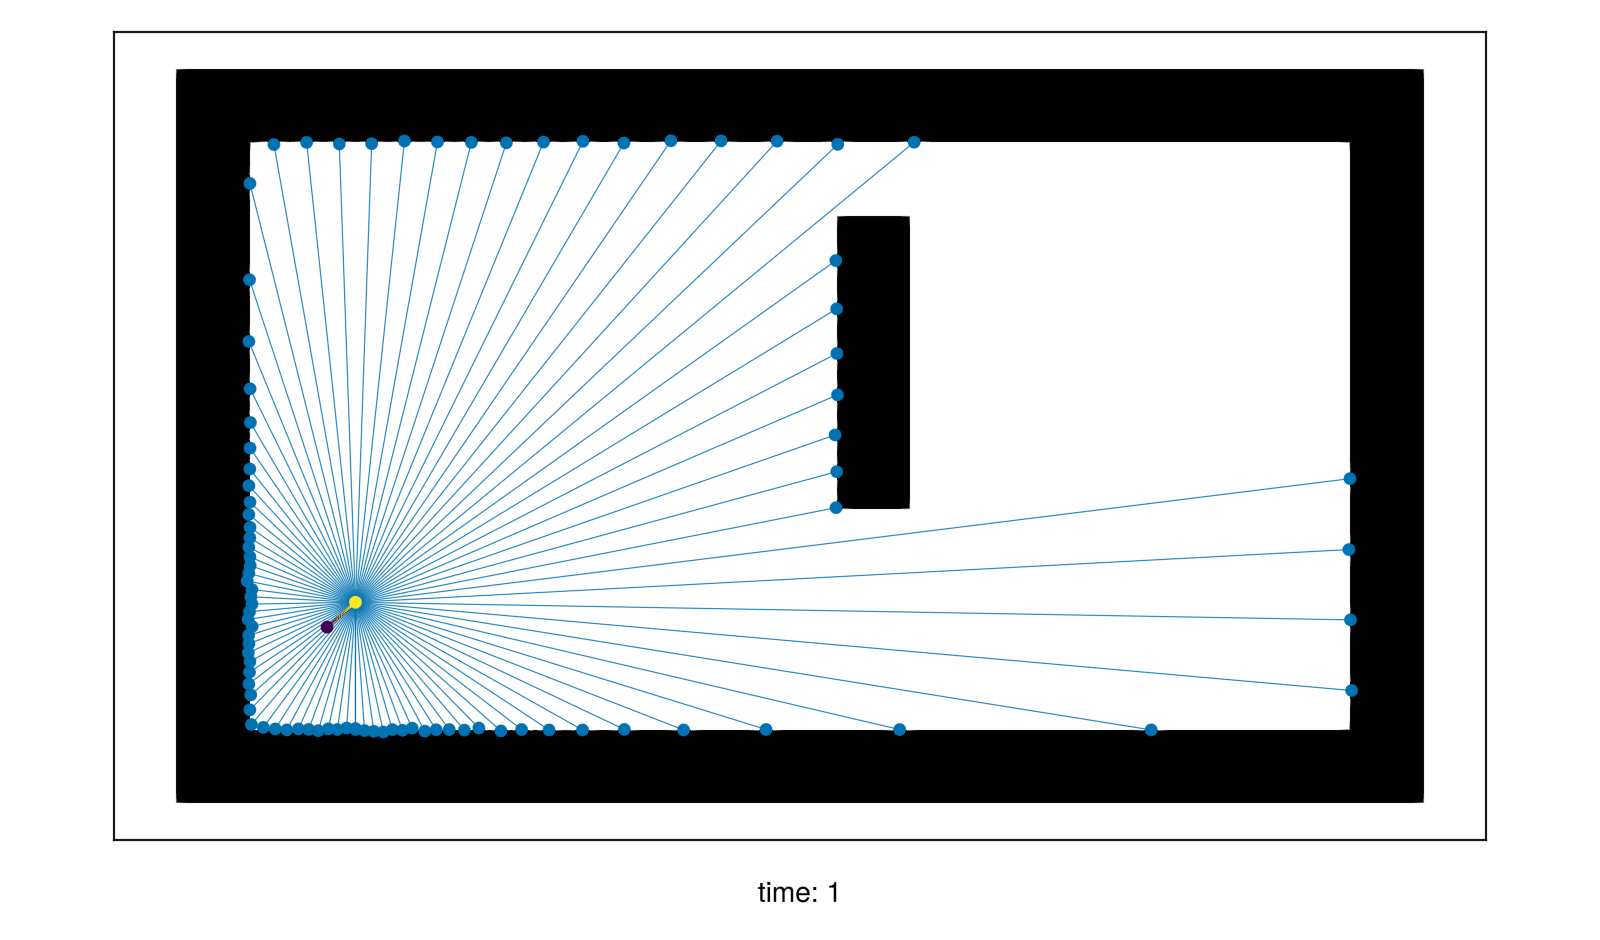

In [159]:
gif_filename = GridWorlds.Viz.trace_gif(
    t -> params.map,
    [pos for (pos, _, _) in GenPOMDPs.state_sequence(tr)],
    GenPOMDPs.observation_retval_sequence(tr),
    # get_args(tr)[1],
    show_lines_to_walls=true,
    framerate=8
)
display("image/gif", read(gif_filename))

## Basic localization inference

In [160]:
obss = GenPOMDPs.observation_sequence(tr);

In [161]:
n_particles = 10
(bpf_init, bpf_update) = bootstrap_pf = GenPOMDPs.pf(
    pomdp,
    get_args(tr)[3],
    (n_particles,), (),
    pre_update = GenPOMDPs.stratified_resample_if_ess_below_one_plus_onetenth_particlecount
)

(GenPOMDPs.var"#initialize#40"{@NamedTuple{map::GridWorlds.FGridWorld, step::@NamedTuple{Δ::Float64, σ::Float64}, obs::@NamedTuple{fov::Float64, n_rays::Int64, orientation::Float64, wall_sensor_args::@NamedTuple{w::Int64, s_noise::Float64, outlier::Float64, outlier_vol::Float64, zmax::Float64, σ::Float64}}}, GenPOMDPs.var"#41#42"{Tuple{Int64}}, GenPOMDPs.var"##StaticGenFunction__ControlledTrajectoryModel#2463"}((map = GridWorlds.FGridWorld(FunctionalCollections.PersistentVector{GridWorlds.GridCell}[[GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall], [GridWorlds.wall, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.wall], [GridWorlds.wall, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, 

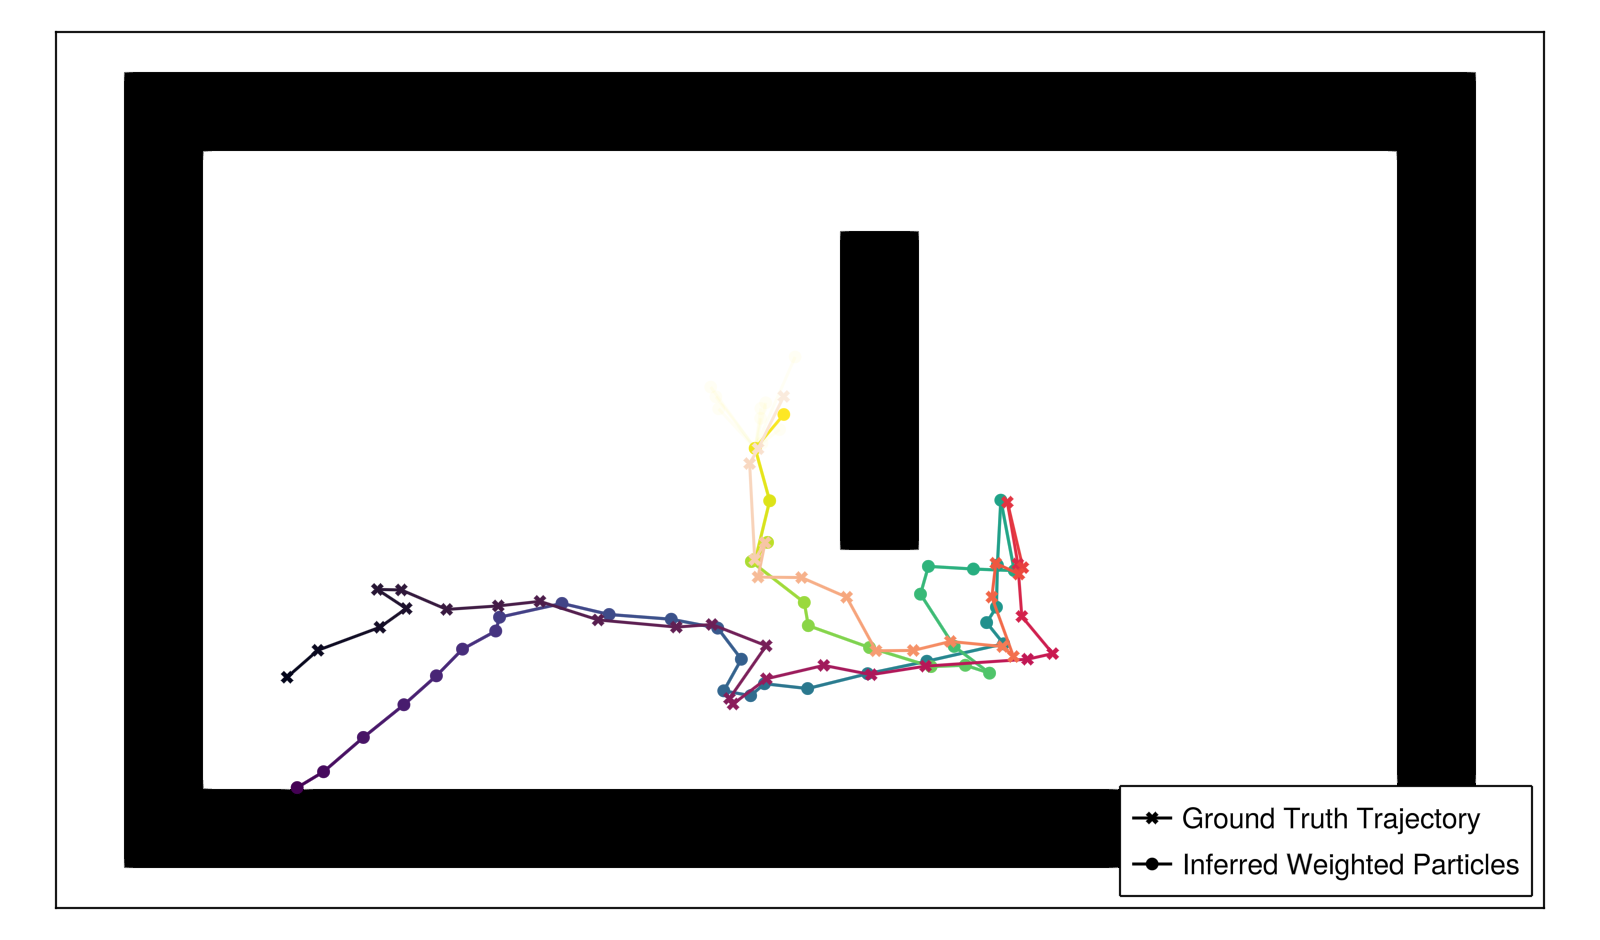

In [162]:
pf_states = GenPOMDPs.map_pf_over_gt_trace(
    bootstrap_pf,
    tr;
    get_intermediates=true
);

GridWorlds.Viz.plot_pf_results(
    get_args(tr)[3].map,
    [pos for (pos, _, _) in GenPOMDPs.state_sequence(tr)],
    [
        [pos for (pos, _, _) in GenPOMDPs.state_sequence(trace)]
        for trace in get_traces(pf_states[end])
    ],
    get_log_weights(pf_states[end])
)

In [172]:
includet("src/inference.jl")

## C2F Init + BPF updates

In [167]:
(t0_grid_args, update_grid_args, _) = default_pf_args(params)

((tau = 1.0, pmin = 1.0e-6, n_iters = 6, init_grid_args = (k = [26, 15], r = [0.6519202405202649, 0.6519202405202649]), initial_pos = [8.5, 5.0]), (tau = 1.0, pmin = 1.0e-6, n_iters = 3, init_grid_args = (k = [9, 9], r = [0.08333333333333333, 0.08333333333333333])), (n_particles = 1, n_groups = 1, ess_threshold = 0.0))

In [165]:
grid_then_b_pf = GenPOMDPs.pf(
    pomdp, get_args(tr)[3],
    obs -> (
        20, # n_particles
        GenSMCP3.SMCP3Update(
            fwd_iterated_grid_init, bwd_iterated_grid_init,
            (trajectory_model, get_args(tr)[3], obs, t0_grid_args, pos_to_init_cm),
            (t0_grid_args, state_to_pos)
        )
    ),
    (action, obs) -> (), # bootstrap update,
    pre_update = GenPOMDPs.stratified_resample_if_ess_below_one_plus_onetenth_particlecount
);

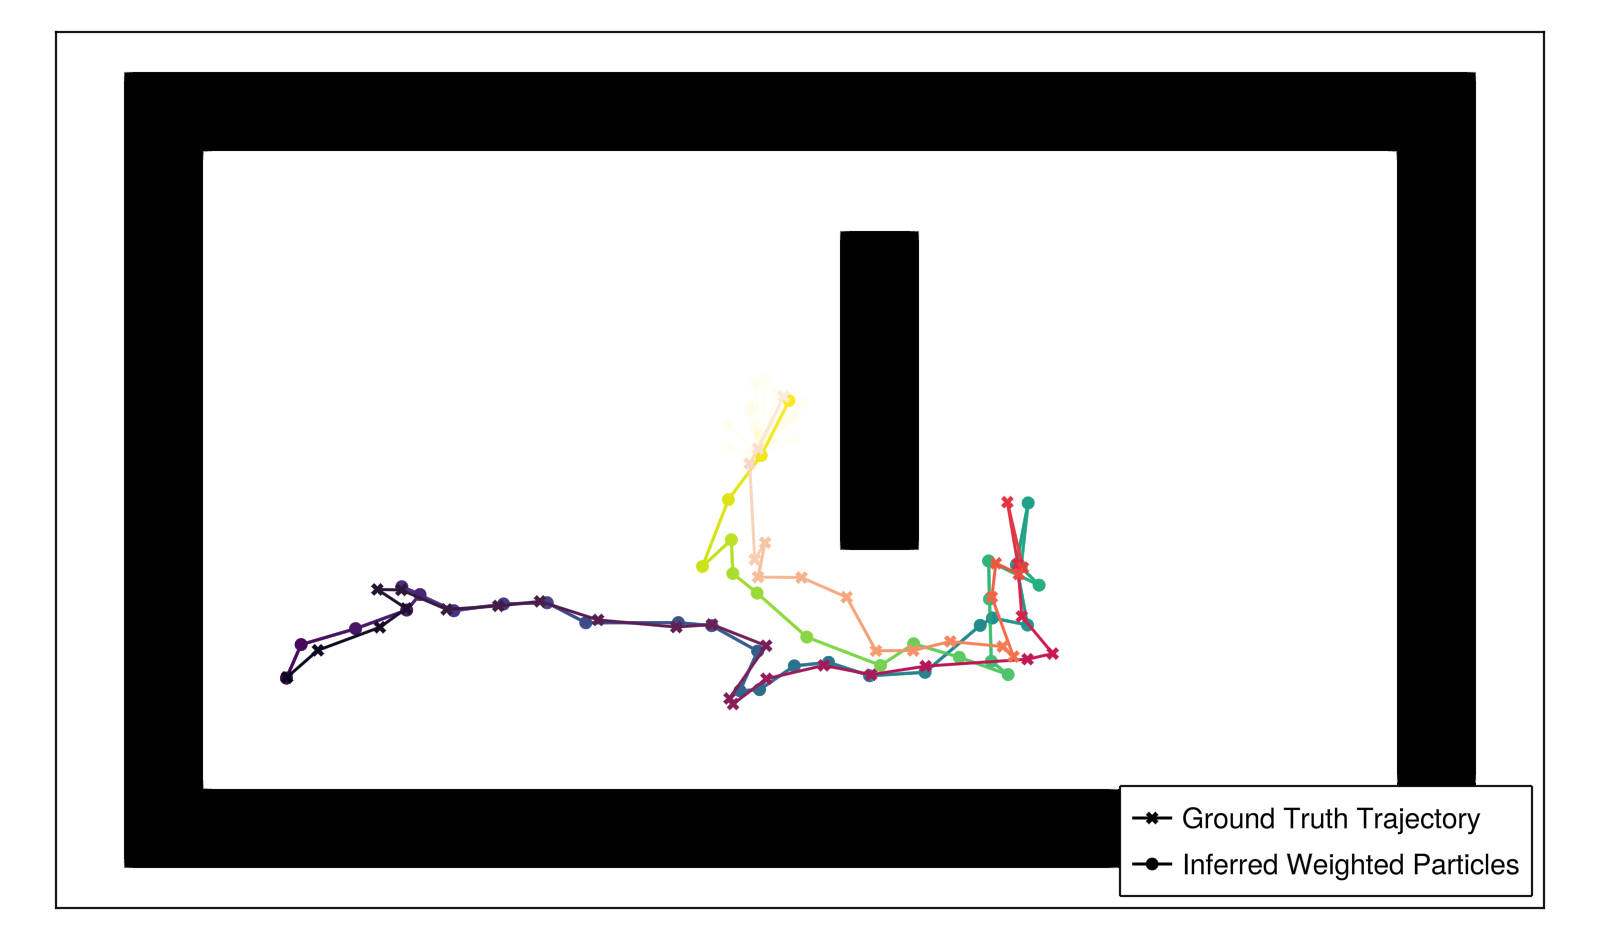

In [175]:
pf_states2 = GenPOMDPs.map_pf_over_gt_trace(
    grid_then_b_pf,
    tr;
    get_intermediates=true
);

GridWorlds.Viz.plot_pf_results(
    get_args(tr)[3].map,
    [pos for (pos, _, _) in GenPOMDPs.state_sequence(tr)],
    [
        [pos for (pos, _, _) in GenPOMDPs.state_sequence(trace)]
        for trace in get_traces(pf_states2[end])
    ],
    get_log_weights(pf_states2[end])
)

## C2F Init + C2F Updates

In [407]:
include("src/inference.jl")
(t0_grid_args, update_grid_args, _) = default_pf_args(params)
update_grid_args

(tau = 1.0, pmin = 1.0e-6, n_iters = 5, init_grid_args = (k = [7, 7], r = [0.4, 0.4]), scaling_factor = 0.6666666666666666)

In [408]:
c2f_pf = GenPOMDPs.pf(
    pomdp, get_args(tr)[3],
    obs -> (
        2, # n_particles
        GenSMCP3.SMCP3Update(
            fwd_iterated_grid, bwd_iterated_grid,
            (
                true, trajectory_model, get_args(tr)[3], obs, t0_grid_args,
                pos_to_init_cm, state_to_pos, nothing, nonoise_nextpos
            ),
            (true, t0_grid_args, state_to_pos, nonoise_nextpos)
        )
    ),
    (action, obs) -> (
        SMCP3Update(
            fwd_iterated_grid, bwd_iterated_grid,
            (
                false, trajectory_model, get_args(tr)[3], obs, update_grid_args,
                pos_to_step_cm, state_to_pos, action, nonoise_nextpos
            ),
            (false, update_grid_args, state_to_pos, nonoise_nextpos)
        
        ),
    ),
    pre_update = GenPOMDPs.stratified_resample_if_ess_below_one_plus_onetenth_particlecount
);

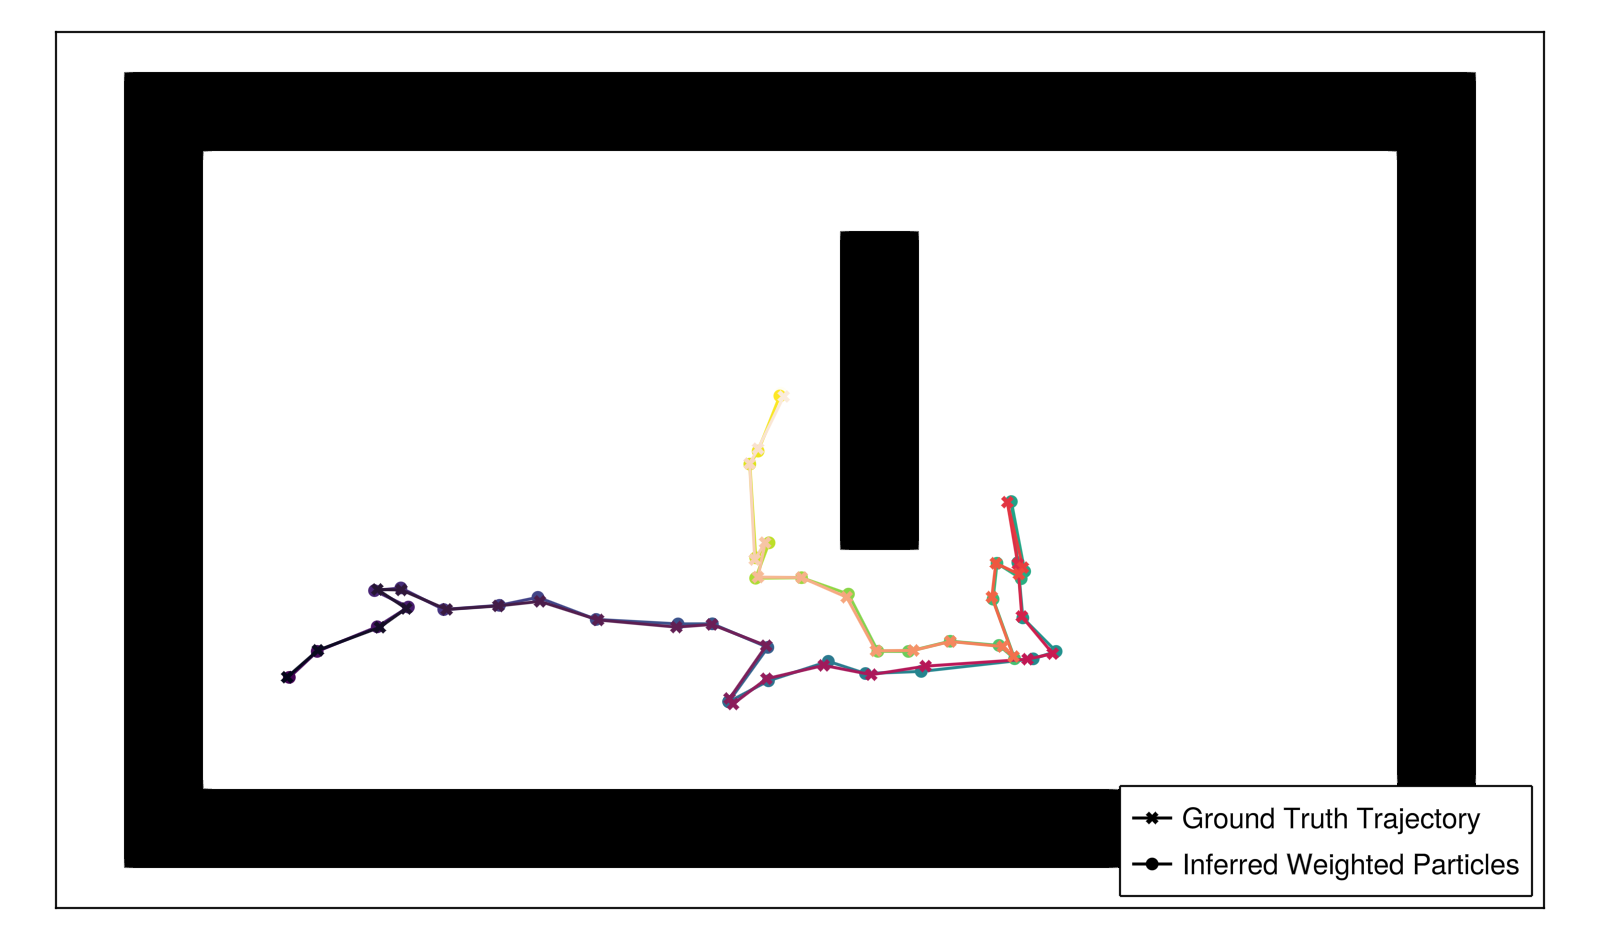

In [409]:
pf_states3 = GenPOMDPs.map_pf_over_gt_trace(
    c2f_pf,
    tr;
    get_intermediates=true
);

f = GridWorlds.Viz.plot_pf_results(
    get_args(tr)[3].map,
    [pos for (pos, _, _) in GenPOMDPs.state_sequence(tr)],
    [
        [pos for (pos, _, _) in GenPOMDPs.state_sequence(trace)]
        for trace in get_traces(pf_states3[end])
    ],
    get_log_weights(pf_states3[end])
)

In [410]:
# Debugging code -- visualize grids by copying println logging 

# vals1 = [[1.8843915972383136, 1.7302005192978165], [2.0510582639049804, 1.7302005192978165], [2.217724930571647, 1.7302005192978165], [2.3843915972383134, 1.7302005192978165], [2.55105826390498, 1.7302005192978165], [2.717724930571647, 1.7302005192978165], [2.8843915972383134, 1.7302005192978165], [3.05105826390498, 1.7302005192978165], [3.217724930571647, 1.7302005192978165], [1.8843915972383136, 1.896867185964483], [2.0510582639049804, 1.896867185964483], [2.217724930571647, 1.896867185964483], [2.3843915972383134, 1.896867185964483], [2.55105826390498, 1.896867185964483], [2.717724930571647, 1.896867185964483], [2.8843915972383134, 1.896867185964483], [3.05105826390498, 1.896867185964483], [3.217724930571647, 1.896867185964483], [1.8843915972383136, 2.0635338526311497], [2.0510582639049804, 2.0635338526311497], [2.217724930571647, 2.0635338526311497], [2.3843915972383134, 2.0635338526311497], [2.55105826390498, 2.0635338526311497], [2.717724930571647, 2.0635338526311497], [2.8843915972383134, 2.0635338526311497], [3.05105826390498, 2.0635338526311497], [3.217724930571647, 2.0635338526311497], [1.8843915972383136, 2.2302005192978163], [2.0510582639049804, 2.2302005192978163], [2.217724930571647, 2.2302005192978163], [2.3843915972383134, 2.2302005192978163], [2.55105826390498, 2.2302005192978163], [2.717724930571647, 2.2302005192978163], [2.8843915972383134, 2.2302005192978163], [3.05105826390498, 2.2302005192978163], [3.217724930571647, 2.2302005192978163], [1.8843915972383136, 2.3968671859644832], [2.0510582639049804, 2.3968671859644832], [2.217724930571647, 2.3968671859644832], [2.3843915972383134, 2.3968671859644832], [2.55105826390498, 2.3968671859644832], [2.717724930571647, 2.3968671859644832], [2.8843915972383134, 2.3968671859644832], [3.05105826390498, 2.3968671859644832], [3.217724930571647, 2.3968671859644832], [1.8843915972383136, 2.5635338526311497], [2.0510582639049804, 2.5635338526311497], [2.217724930571647, 2.5635338526311497], [2.3843915972383134, 2.5635338526311497], [2.55105826390498, 2.5635338526311497], [2.717724930571647, 2.5635338526311497], [2.8843915972383134, 2.5635338526311497], [3.05105826390498, 2.5635338526311497], [3.217724930571647, 2.5635338526311497], [1.8843915972383136, 2.7302005192978163], [2.0510582639049804, 2.7302005192978163], [2.217724930571647, 2.7302005192978163], [2.3843915972383134, 2.7302005192978163], [2.55105826390498, 2.7302005192978163], [2.717724930571647, 2.7302005192978163], [2.8843915972383134, 2.7302005192978163], [3.05105826390498, 2.7302005192978163], [3.217724930571647, 2.7302005192978163], [1.8843915972383136, 2.8968671859644832], [2.0510582639049804, 2.8968671859644832], [2.217724930571647, 2.8968671859644832], [2.3843915972383134, 2.8968671859644832], [2.55105826390498, 2.8968671859644832], [2.717724930571647, 2.8968671859644832], [2.8843915972383134, 2.8968671859644832], [3.05105826390498, 2.8968671859644832], [3.217724930571647, 2.8968671859644832], [1.8843915972383136, 3.0635338526311497], [2.0510582639049804, 3.0635338526311497], [2.217724930571647, 3.0635338526311497], [2.3843915972383134, 3.0635338526311497], [2.55105826390498, 3.0635338526311497], [2.717724930571647, 3.0635338526311497], [2.8843915972383134, 3.0635338526311497], [3.05105826390498, 3.0635338526311497], [3.217724930571647, 3.0635338526311497]]
# vals2 = [[2.05105826390498, 2.3968671859644832], [2.1343915972383134, 2.3968671859644832], [2.217724930571647, 2.3968671859644832], [2.30105826390498, 2.3968671859644832], [2.3843915972383134, 2.3968671859644832], [2.467724930571647, 2.3968671859644832], [2.55105826390498, 2.3968671859644832], [2.6343915972383134, 2.3968671859644832], [2.717724930571647, 2.3968671859644832], [2.05105826390498, 2.4802005192978163], [2.1343915972383134, 2.4802005192978163], [2.217724930571647, 2.4802005192978163], [2.30105826390498, 2.4802005192978163], [2.3843915972383134, 2.4802005192978163], [2.467724930571647, 2.4802005192978163], [2.55105826390498, 2.4802005192978163], [2.6343915972383134, 2.4802005192978163], [2.717724930571647, 2.4802005192978163], [2.05105826390498, 2.5635338526311497], [2.1343915972383134, 2.5635338526311497], [2.217724930571647, 2.5635338526311497], [2.30105826390498, 2.5635338526311497], [2.3843915972383134, 2.5635338526311497], [2.467724930571647, 2.5635338526311497], [2.55105826390498, 2.5635338526311497], [2.6343915972383134, 2.5635338526311497], [2.717724930571647, 2.5635338526311497], [2.05105826390498, 2.6468671859644832], [2.1343915972383134, 2.6468671859644832], [2.217724930571647, 2.6468671859644832], [2.30105826390498, 2.6468671859644832], [2.3843915972383134, 2.6468671859644832], [2.467724930571647, 2.6468671859644832], [2.55105826390498, 2.6468671859644832], [2.6343915972383134, 2.6468671859644832], [2.717724930571647, 2.6468671859644832], [2.05105826390498, 2.7302005192978163], [2.1343915972383134, 2.7302005192978163], [2.217724930571647, 2.7302005192978163], [2.30105826390498, 2.7302005192978163], [2.3843915972383134, 2.7302005192978163], [2.467724930571647, 2.7302005192978163], [2.55105826390498, 2.7302005192978163], [2.6343915972383134, 2.7302005192978163], [2.717724930571647, 2.7302005192978163], [2.05105826390498, 2.8135338526311497], [2.1343915972383134, 2.8135338526311497], [2.217724930571647, 2.8135338526311497], [2.30105826390498, 2.8135338526311497], [2.3843915972383134, 2.8135338526311497], [2.467724930571647, 2.8135338526311497], [2.55105826390498, 2.8135338526311497], [2.6343915972383134, 2.8135338526311497], [2.717724930571647, 2.8135338526311497], [2.05105826390498, 2.8968671859644832], [2.1343915972383134, 2.8968671859644832], [2.217724930571647, 2.8968671859644832], [2.30105826390498, 2.8968671859644832], [2.3843915972383134, 2.8968671859644832], [2.467724930571647, 2.8968671859644832], [2.55105826390498, 2.8968671859644832], [2.6343915972383134, 2.8968671859644832], [2.717724930571647, 2.8968671859644832], [2.05105826390498, 2.9802005192978163], [2.1343915972383134, 2.9802005192978163], [2.217724930571647, 2.9802005192978163], [2.30105826390498, 2.9802005192978163], [2.3843915972383134, 2.9802005192978163], [2.467724930571647, 2.9802005192978163], [2.55105826390498, 2.9802005192978163], [2.6343915972383134, 2.9802005192978163], [2.717724930571647, 2.9802005192978163], [2.05105826390498, 3.0635338526311497], [2.1343915972383134, 3.0635338526311497], [2.217724930571647, 3.0635338526311497], [2.30105826390498, 3.0635338526311497], [2.3843915972383134, 3.0635338526311497], [2.467724930571647, 3.0635338526311497], [2.55105826390498, 3.0635338526311497], [2.6343915972383134, 3.0635338526311497], [2.717724930571647, 3.0635338526311497]]
# vals3 = [[2.30105826390498, 2.5635338526311493], [2.342724930571647, 2.5635338526311493], [2.3843915972383134, 2.5635338526311493], [2.42605826390498, 2.5635338526311493], [2.467724930571647, 2.5635338526311493], [2.5093915972383134, 2.5635338526311493], [2.55105826390498, 2.5635338526311493], [2.592724930571647, 2.5635338526311493], [2.6343915972383134, 2.5635338526311493], [2.30105826390498, 2.6052005192978163], [2.342724930571647, 2.6052005192978163], [2.3843915972383134, 2.6052005192978163], [2.42605826390498, 2.6052005192978163], [2.467724930571647, 2.6052005192978163], [2.5093915972383134, 2.6052005192978163], [2.55105826390498, 2.6052005192978163], [2.592724930571647, 2.6052005192978163], [2.6343915972383134, 2.6052005192978163], [2.30105826390498, 2.646867185964483], [2.342724930571647, 2.646867185964483], [2.3843915972383134, 2.646867185964483], [2.42605826390498, 2.646867185964483], [2.467724930571647, 2.646867185964483], [2.5093915972383134, 2.646867185964483], [2.55105826390498, 2.646867185964483], [2.592724930571647, 2.646867185964483], [2.6343915972383134, 2.646867185964483], [2.30105826390498, 2.6885338526311493], [2.342724930571647, 2.6885338526311493], [2.3843915972383134, 2.6885338526311493], [2.42605826390498, 2.6885338526311493], [2.467724930571647, 2.6885338526311493], [2.5093915972383134, 2.6885338526311493], [2.55105826390498, 2.6885338526311493], [2.592724930571647, 2.6885338526311493], [2.6343915972383134, 2.6885338526311493], [2.30105826390498, 2.7302005192978163], [2.342724930571647, 2.7302005192978163], [2.3843915972383134, 2.7302005192978163], [2.42605826390498, 2.7302005192978163], [2.467724930571647, 2.7302005192978163], [2.5093915972383134, 2.7302005192978163], [2.55105826390498, 2.7302005192978163], [2.592724930571647, 2.7302005192978163], [2.6343915972383134, 2.7302005192978163], [2.30105826390498, 2.771867185964483], [2.342724930571647, 2.771867185964483], [2.3843915972383134, 2.771867185964483], [2.42605826390498, 2.771867185964483], [2.467724930571647, 2.771867185964483], [2.5093915972383134, 2.771867185964483], [2.55105826390498, 2.771867185964483], [2.592724930571647, 2.771867185964483], [2.6343915972383134, 2.771867185964483], [2.30105826390498, 2.8135338526311493], [2.342724930571647, 2.8135338526311493], [2.3843915972383134, 2.8135338526311493], [2.42605826390498, 2.8135338526311493], [2.467724930571647, 2.8135338526311493], [2.5093915972383134, 2.8135338526311493], [2.55105826390498, 2.8135338526311493], [2.592724930571647, 2.8135338526311493], [2.6343915972383134, 2.8135338526311493], [2.30105826390498, 2.8552005192978163], [2.342724930571647, 2.8552005192978163], [2.3843915972383134, 2.8552005192978163], [2.42605826390498, 2.8552005192978163], [2.467724930571647, 2.8552005192978163], [2.5093915972383134, 2.8552005192978163], [2.55105826390498, 2.8552005192978163], [2.592724930571647, 2.8552005192978163], [2.6343915972383134, 2.8552005192978163], [2.30105826390498, 2.896867185964483], [2.342724930571647, 2.896867185964483], [2.3843915972383134, 2.896867185964483], [2.42605826390498, 2.896867185964483], [2.467724930571647, 2.896867185964483], [2.5093915972383134, 2.896867185964483], [2.55105826390498, 2.896867185964483], [2.592724930571647, 2.896867185964483], [2.6343915972383134, 2.896867185964483]]
# pts1, pts2, pts3 = map(Makie.Point2, vals1), map(Makie.Point2, vals2), map(Makie.Point2, vals3)

# ax = Makie.contents(f[1, 1])[1]
# for pts in [pts1, pts2, pts3]
#     Makie.scatter!(ax, pts, markersize=5, color=:red)
# end
# f

In [411]:
# Debugging code -- same viz as above, but in an interactive where I can zoom in
# display(f)